In [2]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, 'functions/')
# from h5_tools import *
from tools import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

# Functions

In [3]:
def get_diff_coeff_library(filename='../03-source/diffusion_coefficient'):
    """Return dataframe with diffusion coefficients from the experimental data
    """
    df = pd.read_pickle(filename)
    df['temperature'] = df['temperature'].replace(243, 240)
    df['transmission'] = df['transmission'].str.replace('%', '')
    df['transmission'] = df['transmission'].str.replace('nan', '100')
    df['transmission'] = df['transmission'].str.replace('~', '')
    df['transmission'] = df['transmission'].astype(float)
    
    return df

def load_npz_data(filename):
    """Loads data from npz file and return a dictionary
    """
    file = np.load(filename)
    data = {key: file[key] for key in file.files}

    return data

# Load Viscosities

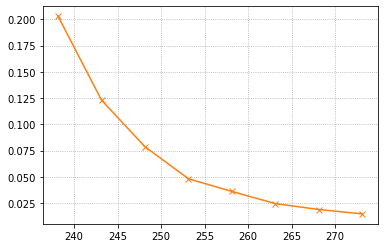

In [4]:
# form dx.doi.org/10.1021/je101164q |J. Chem. Eng. Data 2011, 56, 1397–1406 in mPa*s
eta_50w_ref = {273.15: 14.6, 268.15: 18.8, 263.15: 24.4, 258.15: 36.0, 253.15: 48.1, 248.15: 78.6, 243.15: 123, 238.15: 203}

lists = eta_50w_ref.items()
ts, etas_ref = zip(*lists)
plt.plot(ts, np.array(etas_ref)*1e-3, label='50 w% = 23 mol% (paper)', marker='x', c='C1')

# they overlap with the values in the pandas dataframe

In [5]:
# Rh = 5.785e-9
# Tsref, Dref = [], []

# for T in eta_50w_ref.keys():
#     Tsref.append(T)
#     # print(T, eta_50w_ref[T])
#     Dref.append(D_coeff(T=T, eta=eta_50w_ref[T]*1e-3, Rh=Rh))
# Dref

In [6]:
etas = viscosity()
etas#['50w%']

,temp,50w%,50v%,60v%,c1,c2,c3
0,300,0.004674,0.006357,0.011691,0.006726,0.008012,0.010947
1,290,0.006771,0.009497,0.018606,0.010106,0.012256,0.017301
2,280,0.010448,0.015197,0.032089,0.016282,0.020171,0.029595
3,270,0.017490,0.026578,0.061359,0.028708,0.036484,0.056042
4,260,0.032565,0.052163,0.134000,0.056900,0.074554,0.120980
5,250,0.069890,0.119340,0.348570,0.131720,0.179070,0.310370
6,240,0.182690,0.337190,1.149900,0.377570,0.536700,1.007000
7,230,0.635210,1.289300,5.300200,1.469200,2.204400,4.550300
8,220,3.416900,7.785200,40.015000,9.060500,14.508000,33.555000
9,210,37.846000,98.826000,657.370000,117.890000,203.600000,536.700000


In [7]:
f = np.load("../03-source/viscosity_NP.npz") # 23 mol% = 50 w% = 44 v%
f.files

['T_np', 'eta_np', 'T_gly', 'eta_gly']

# Plots

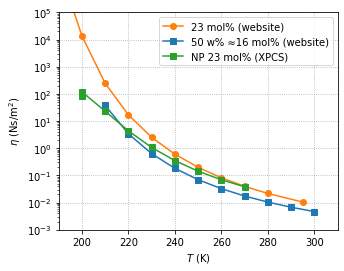

In [21]:
plt.figure(figsize=(5,4))


plt.plot(f['T_gly'], f['eta_gly'], label='23 mol% (website)', c='C1', marker='o')
fact = 1 #f['eta_gly'][1] / etas['50w%'].iloc[2]
plt.plot(etas['temp'], etas['50w%']*fact, label='50 w% ≈16 mol% (website)', c='C0', ls='-', marker='s')

# from LLT ID10
plt.plot(f['T_np'], f['eta_np'], label='NP 23 mol% (XPCS)', c='C2', marker='s')

plt.yscale('log')
plt.legend()
plt.xlim(190,310)
plt.ylim(1e-3,1e5)
# plt.ylabel("$\eta$ (Pa$\cdot$s)")
plt.ylabel("$\eta$ (Ns/m$^2$)")
plt.xlabel("$T$ (K)")
# plt.savefig('../06-figs/eta_id10_llt.png', dpi=300)

In [22]:
f['eta_gly']

array([1.0471e-02, 2.1720e-02, 3.9632e-02, 8.1849e-02, 1.9911e-01,
       6.0600e-01, 2.5357e+00, 1.7063e+01, 2.4570e+02, 1.3837e+04,
       2.6422e+05, 1.6325e+07, 1.0385e+10, 4.1674e+15])

In [23]:
f['T_gly']

array([295, 280, 270, 260, 250, 240, 230, 220, 210, 200, 195, 190, 185,
       180])